In [387]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import spatter_util

# Spatter Plots

This notebook will guide you through running standard Spatter testsuites and adding the results to the plots found in our MEMSYS'20 paper, which you can read [here](https://dl.acm.org/doi/abs/10.1145/3422575.3422794). Specifically, we will be adding your data to Figures 3, 5, and 9.

**Important**: Before you run this notebook, you should have already built Spatter. Please view the README in the top level directory to do so. Once you've built Spatter, note the build directory, and return to this notebook. 

**Note:** Although a new combined Gather/Scatter kernel is planned, it is not yet part of this notebook. 

To get started, fill out the information in the table below about your system. By default, this notebook contains 

In [278]:
# Configuration Information
build_dir      = '../build_omp_gnu' # Relative to the directory containing this notebook
stream_copy_bw =  58543.9           # STREAM bw in MB/s - if you don't know this just use the value below 
                                    # called "Spatter STREAM-like Gather bandwidth" You can enter 0 for now.
platform_name  = 'M1'               # Used for plot legends
system_type    = 'cpu'              # Change to 'gpu' if you have build a CUDA or OpenCL backend

In [ ]:
# Testsuite Files
# You should not edit these. They are merely listed here in case you wish to reference these files
cpu_ustride = '../standard

## Examining Spatter Output
First, let's look at how we can use Spatter to get a number similar to what John McCalpin's [STREAM](https://www.cs.virginia.edu/stream/) would give us. 

To accomplish this in Spatter, we want to create a pattern that will read in every element of an array with no reuse. This means we want an index buffer containing the numbers $0$ to $N-1$, and a `delta` of $N$. The value of $N$ does not change the data that is read, but may have performance implications for the architecture you're running on. A good value for CPUs is 8, and a good value for GPUs is 256. We want to run this test as a sanity check before running the more interested tests. 

One caveat when comparing to STREAM is that Spatter is designed to only produce Reads in Gather mode, and to only produce writes in Scatter mode. The numbers should still be similar, however. 

We'll write this one out by hand so we can look at some of the options Spatter supports. After this, we'll just run the scripts that run the standard testsuites. This test will require 1GiB of memory.

In [94]:
N      = 8                  # Index buffer length, as described above
index  = f'-pUNIFORM:{N}:1' # This is a shorthand that Spatter supports meaning "Uniform stride, length N, gap 1
                            # You could also write -p0,1,2,3,4,5,6,7
delta  = f'-d{N}'           # This is the delta applied to the base address between gathers/scatters
length = f'-l{2**24}'       # The -l (--length) option specifies how many gathers or scatters to perform
                            # With an index buffer of length 8, and 8 bytes per element, this will be 2**3 * 2**3 * 2**24 = 1GiB of data read

os.system(f'{build_dir}/spatter {index} {delta} {length} | tee stream-like-read-custom{system_type}.txt')


Running Spatter version 0.4
Compiler: SPAT_C_NAME ver. 14.0.0.14000029
Compiler Location: /usr/bin/gcc
Backend: OPENMP
Aggregate Results? YES

Run Configurations
[ {'name':'UNIFORM', 'kernel':'Gather', 'pattern':[0,1,2,3,4,5,6,7], 'delta':8, 'length':16777216, 'agg':10, 'wrap':1, 'threads':8} ]

config  time(s)      bw(MB/s)    
0       0.01929      55660.2     

Min         25%          Med          75%          Max         
55660.2      55660.2      55660.2      55660.2      55660.2     
H.Mean       H.StdErr    
55660.2      0           


0

### Spatter Output

There are 4 sections in the above output:
1. Build information
1. Run configuations

    - In this case there is only one. Spatter supports a JSON input to specify multiple run configuations. This saves time allocating memory as it can be re-used between benchmark runs. 
        
1. Time and effective bandwidth per configuration. 

    - In the run configuration, you'll see that "agg" is set to 10, meaning the configuation is an aggregate across 10 runs. We take the minimum time of all aggregated runs. 
    
1. Summary information

    - These numbers, particularly the harmonic mean, serve as a single performance number for the run configurations.

In [279]:
# Read the output file and get the bandwidth. We'll use a utility function for this further in the notebook
read_bw = float(os.popen(f'grep config --context=1 < stream-like-read-custom{system_type}.txt | tail -n 1 | cut -w -f3').read())
if (stream_copy_bw != 0):
    print(f'Spatter STREAM-like Gather bandwidth is {read_bw} MB/s, which is {100*read_bw/stream_copy_bw:.2f}% of STREAM')
else:
    print(f'Spatter STREAM-like Gather bandwidth is {read_bw} MB/s. NOTE: Please enter this value for \'stream_copy_bandwidth\'')

Spatter STREAM-like Gather bandwidth is 55660.2 MB/s, which is 95.07% of STREAM


## Standard Suite 1: STREAM-like

Let's run the STREAM-like suite. We won't make a plot from this data, but we'll use this to see how the other suites are run. This test will require 1GiB to run.

In [282]:
suite = f'../standard-suite/basic-tests/{system_type}-stream.json'
os.system(f'{build_dir}/spatter -pFILE={suite} | tee stream_custom{system_type}.txt')

Reading patterns from ../standard-suite/basic-tests/cpu-stream.json.

Running Spatter version 0.4
Compiler: SPAT_C_NAME ver. 14.0.0.14000029
Compiler Location: /usr/bin/gcc
Backend: OPENMP
Aggregate Results? YES

Run Configurations
[ {'name':'UNIFORM', 'kernel':'Scatter', 'pattern':[0,1,2,3,4,5,6,7], 'delta':8, 'length':16777216, 'agg':10, 'wrap':1, 'threads':8},
  {'name':'UNIFORM', 'kernel':'Gather', 'pattern':[0,1,2,3,4,5,6,7], 'delta':8, 'length':16777216, 'agg':10, 'wrap':1, 'threads':8} ]

config  time(s)      bw(MB/s)    
0       0.02344      45815.9     
1       0.01899      56542.5     

Min         25%          Med          75%          Max         
45815.9      45815.9      56542.5      56542.5      56542.5     
H.Mean       H.StdErr    
50617.2      3750.77     


0

In [283]:
stream_df = spatter_util.file2df(f'stream_custom{system_type}.txt')
print(f'Gather  Bandwidth: {stream_df["bw(MB/s)"][1]} MB/s') # The second pattern is a gather kernel
print(f'Scatter Bandwidth: {stream_df["bw(MB/s)"][0]} MB/s') # The first pattern is a scatter kernel

Gather  Bandwidth: 56542.5 MB/s
Scatter Bandwidth: 45815.9 MB/s


## Standard Suite 2: Uniform Stride

This suite runs gather and scatter patterns at power of 2 strides, from 1 to 128. Because we are access doubles, a stride of 8 means we are accessing 1 element from every 64-byte cache line. We expect to see effective bandwidth roughly level out at this point, although this is not the case on all systems! You can check out the paper for more on this plot!

This test will require 2GB of memory. The plots in the paper used 16 GB but we want this notebook to run quickly on laptops with less memory.

In [284]:
# Run the suite

suite = f'../standard-suite/basic-tests/{system_type}-ustride.json'
os.system(f'{build_dir}/spatter -pFILE={suite} > ustride_custom{system_type}.txt')
ustride_df = spatter_util.file2df(f'ustride_custom{system_type}.txt')
ustride_df = ustride_df.rename(columns={'bw(MB/s)':'bw'})

In [285]:
# Concatenate the new data to the old data
with open('pattern_results_ext.pkl', 'rb') as file:
    df = pickle.load(file)
    
# We ran with many different length patterns to see which was best. As mentioned above, 8 is 
# good for CPUs and 256 is good for GPUs. Set N above to use a different set of experiments. 
df = df[df['pat_len'] == N]
df = pd.concat([df, ustride_df], ignore_index=True)

# Just keep the ustride experiments from the old data
df = df[df['experiment'] == 'ustride']

# Remove Cascade Lake as it's very similar to Skylake
df = df[df['arch']!='clx']

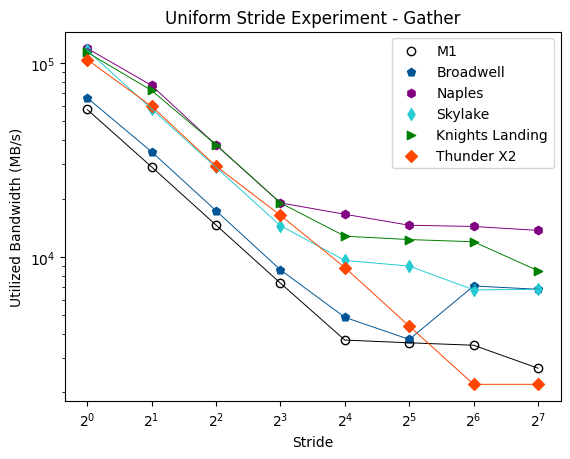

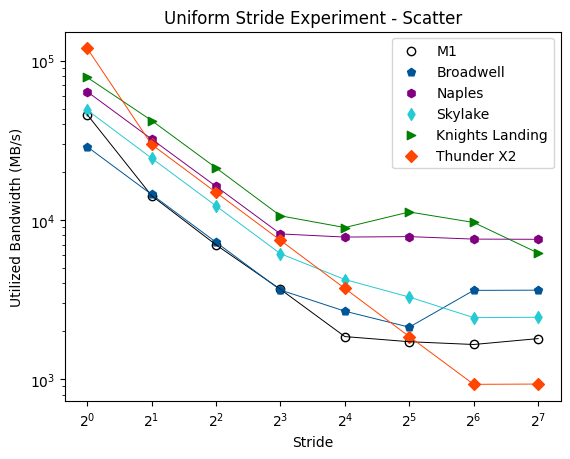

In [286]:
def ustride_plot(kernel):
    df_ustride = df[df['kernel']==kernel]
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_title(f'Uniform Stride Experiment - {kernel}')
    ax.set_ylabel('Utilized Bandwidth (MB/s)')
    ax.set_xlabel('Stride')
    
    for arch in set(df['arch']):    
        if (arch == 'customcpu' or arch == 'customgpu'):
            edgecolor = 'black'
            linecolor = 'black'
            label = platform_name
        else:
            edgecolor = None
            linecolor = spatter_util.COLORS[arch]
            label = spatter_util.ALLNAMES[arch]
            
        yvals = df_ustride[df_ustride['arch']==arch]['bw']
        xvals = range(1, len(yvals)+1)
        sym = spatter_util.SYMBOLS[arch]
        ax.scatter(xvals, yvals, color=spatter_util.COLORS[arch], edgecolors=edgecolor, label=label, marker=sym)
        ax.plot(xvals, yvals, color=linecolor, linewidth=0.7)
        
    string_labels = []
    for i in range(0,len(yvals)):
        string_labels.append(r"$2^{%d}$" % i)

    plt.xticks(range(1,len(yvals)+1),string_labels)
    
    ax.legend()
    plt.show()
    
ustride_plot('Gather')
ustride_plot('Scatter')

Your data should appear as white circles with a black outline. This corresponds to Figure 3 in the paper. If you build for GPU, and set the Configuration Information above appropriately, you can use this same process to recreate Figure 5.

## Standard Suite 3: Application Patterns

The plots for app patterns are much more complicated, but their strucure allows us to compare systems both in terms of the absolute bandwdith they utilize for each pattern (by looking at the y-value of the points) as well as the percent of the available bandwidth they utilize (by looking at the distance of each point from the y=x line, which represents STREAM or Stride-1 bandwidth. 

The plots in the paper contain patterns from PENNANT and LULESH. We'll run those two, but you can also run the Nekbone and AMG patterns if you like.

The PENNANT patterns may take a couple minutes to run.

In [306]:
if (system_type == 'cpu'):
    lulesh_suite  = '../standard-suite/app-traces/lulesh.json'
    pennant_suite = '../standard-suite/app-traces/pennant.json'
else: 
    lulesh_suite  = '../standard-suite/app-traces/lulesh_gpu.json'
    pennant_suite = '../standard-suite/app-traces/pennant_gpu.json'

os.system(f'{build_dir}/spatter -pFILE={lulesh_suite}  > lulesh_custom{system_type}.txt')
os.system(f'{build_dir}/spatter -pFILE={pennant_suite} > pennant_custom{system_type}.txt')

0

In [386]:
df_lulesh  = spatter_util.file2df(f'lulesh_custom{system_type}.txt')
df_pennant = spatter_util.file2df(f'pennant_custom{system_type}.txt')

notebook_df    = pd.concat([df_lulesh, df_pennant], ignore_index=True)
ustride_df     = spatter_util.file2df(f'ustride_custom{system_type}.txt') # Read this in again without re-naming
notebook_df    = pd.concat([ustride_df, notebook_df], ignore_index=True) # Join data from ustride above, we need this for the y=x line on the plot
notebook_system_type = system_type # Used by the plotting script

# Optional - Remove systems from the plot that overlap with your system. They are named: ['bdw', 'npl', 'tx2', 'titan', 'p100', 'gv100']
notebook_remove = ['bdw', 'npl']

# The plotting script also imports spatter_util so we can change values here
spatter_util.ALLNAMES['customcpu'] = platform_name 

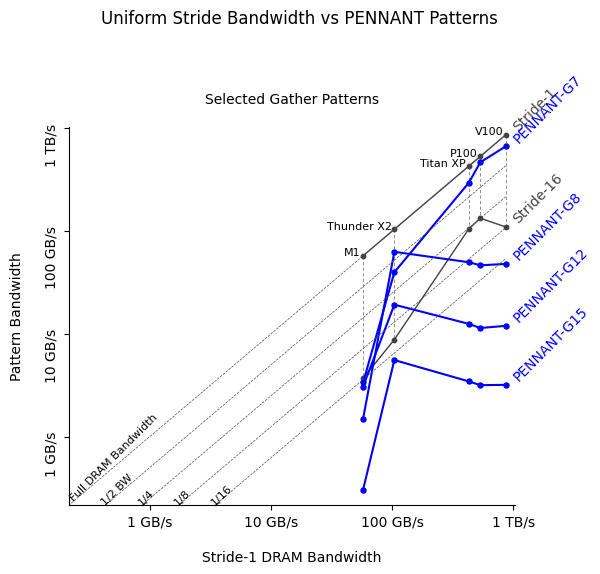

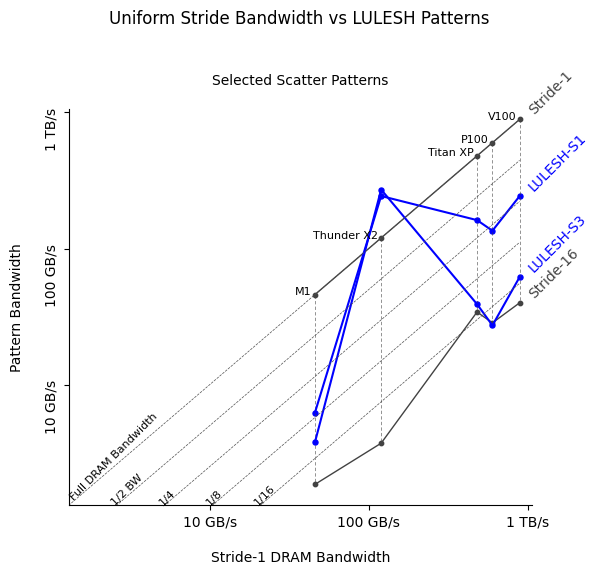

In [384]:
# We'll just call a scrip to make this one -- it's too complicated to include here
%run -i 'bwbw_plot.py' 'Gather'
%run -i 'bwbw_plot.py' 'Scatter'

# Next Steps

- Dig into other Spatter options in the [README.md](https://github.com/hpcgarage/spatter#readme)

- Capture app patterns for your app with our [DyanamoRIO tracing tool](https://github.com/hpcgarage/dr-gather-scatter-trace). (Note: This tool isn't quite ready to generate JSON input for Spatter. Let us know if you're intested in using it!)

- See more experiments in our [paper](https://dl.acm.org/doi/abs/10.1145/3422575.3422794)

## Issues and Improvements

Have issues running this notebook? Have ideas for improving or extending Spatter? Submit an issue [here](https://github.com/hpcgarage/spatter/issues), or submit a PR!

